In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')

## 데이터셋 로딩

In [38]:
df = pd.read_csv("multipleChoiceResponses.csv", engine='python')
useful_list = "GenderSelect Country Age CurrentJobTitleSelect LanguageRecommendationSelect FormalEducation MajorSelect RemoteWork CompensationAmount CompensationCurrency".split(" ")

df = df[useful_list]
df['CompensationAmount'] = df['CompensationAmount'].str.replace(",", "")
df = df.loc[~(df['CompensationAmount'].isna() | df['CompensationCurrency'].isna() )]



## 이상치 제거

In [39]:

# 뜬금 없이 화폐 표기에 SPL 이라고 표시해 에러를 유발하는 행 삭제
df = df.drop(12623)


# 금액란에 -, 0, 소숫점 등을 기록한 데이터 삭제
weird_remove_list = df['CompensationAmount'].sort_values().head(47).index.tolist()
df = df.drop(weird_remove_list)


# 금액을 float로 변경
df['CompensationAmount'] = df['CompensationAmount'].astype(float)

In [40]:
conversion_rate = pd.read_csv("conversionRates.csv", engine='python')
conversion_rate = conversion_rate.drop('Unnamed: 0', axis=1)
conversion_rate = conversion_rate.set_index('originCountry')
conversion_rate_dict = conversion_rate.to_dict()['exchangeRate']

def conversion(row):
    item = row['CompensationCurrency']
    return conversion_rate_dict[item]

# 계산을 위한 임시 칼럼 제작
df['con_rate'] = df.apply(conversion, axis=1)

# USD에 맞춘 실 소득 계산
df['incom_by_USD'] = df['CompensationAmount'] * df['con_rate']

# 쓸모없어진 칼럼 제거
df = df.drop('CompensationAmount	CompensationCurrency	con_rate'.split(), axis=1)

In [41]:
df['incom_by_USD'].sort_values()

5952     6.000000e-02
1565     1.588130e-01
1656     2.264900e-01
10935    2.343000e-01
7979     2.421100e-01
             ...     
12808    2.000000e+06
4481     2.395469e+06
12531    2.500000e+06
15678    4.498900e+06
3013     9.999999e+06
Name: incom_by_USD, Length: 4329, dtype: float64

In [11]:
df['Age'].sort_values()

index
7862      0.0
5018      1.0
1796     16.0
3291     18.0
2230     18.0
         ... 
13789     NaN
13862     NaN
14283     NaN
15167     NaN
15633     NaN
Name: Age, Length: 4217, dtype: float64

In [42]:
# 소득이 너무 크거나 작은 이상치 제거 (터키 펜스 turkey fences)
# Series 를 넣었더니 인덱스를 반환함 (고유인덱스는 아님)

def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    print("q1 :", q1)
    print("q3 :", q3)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))[0].tolist()

In [43]:
temp_data = df['incom_by_USD']
outliers_iqr(temp_data)
temp_df = df.reset_index()
df = temp_df.drop(outliers_iqr(temp_data)).set_index('index')

q1 : 21524.868000000002
q3 : 96277.20000000001
q1 : 21524.868000000002
q3 : 96277.20000000001


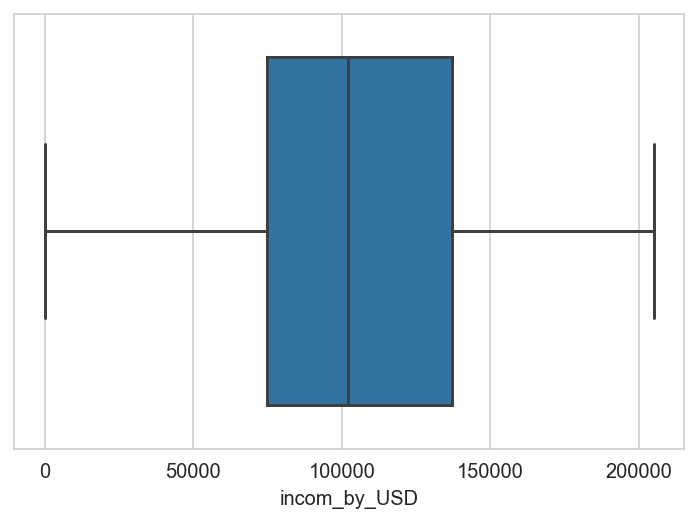

In [48]:
sns.boxplot(df.loc[df['Country'] == 'United States']['incom_by_USD'])

In [49]:
df.loc[df['Country'] == 'United States']['incom_by_USD'].sort_values()

index
4229         11.12
6225         96.00
12506       100.00
11898       102.00
5251        155.00
           ...    
12148    200000.00
16525    200000.00
6224     201000.00
7752     205000.00
4414     205000.00
Name: incom_by_USD, Length: 1135, dtype: float64

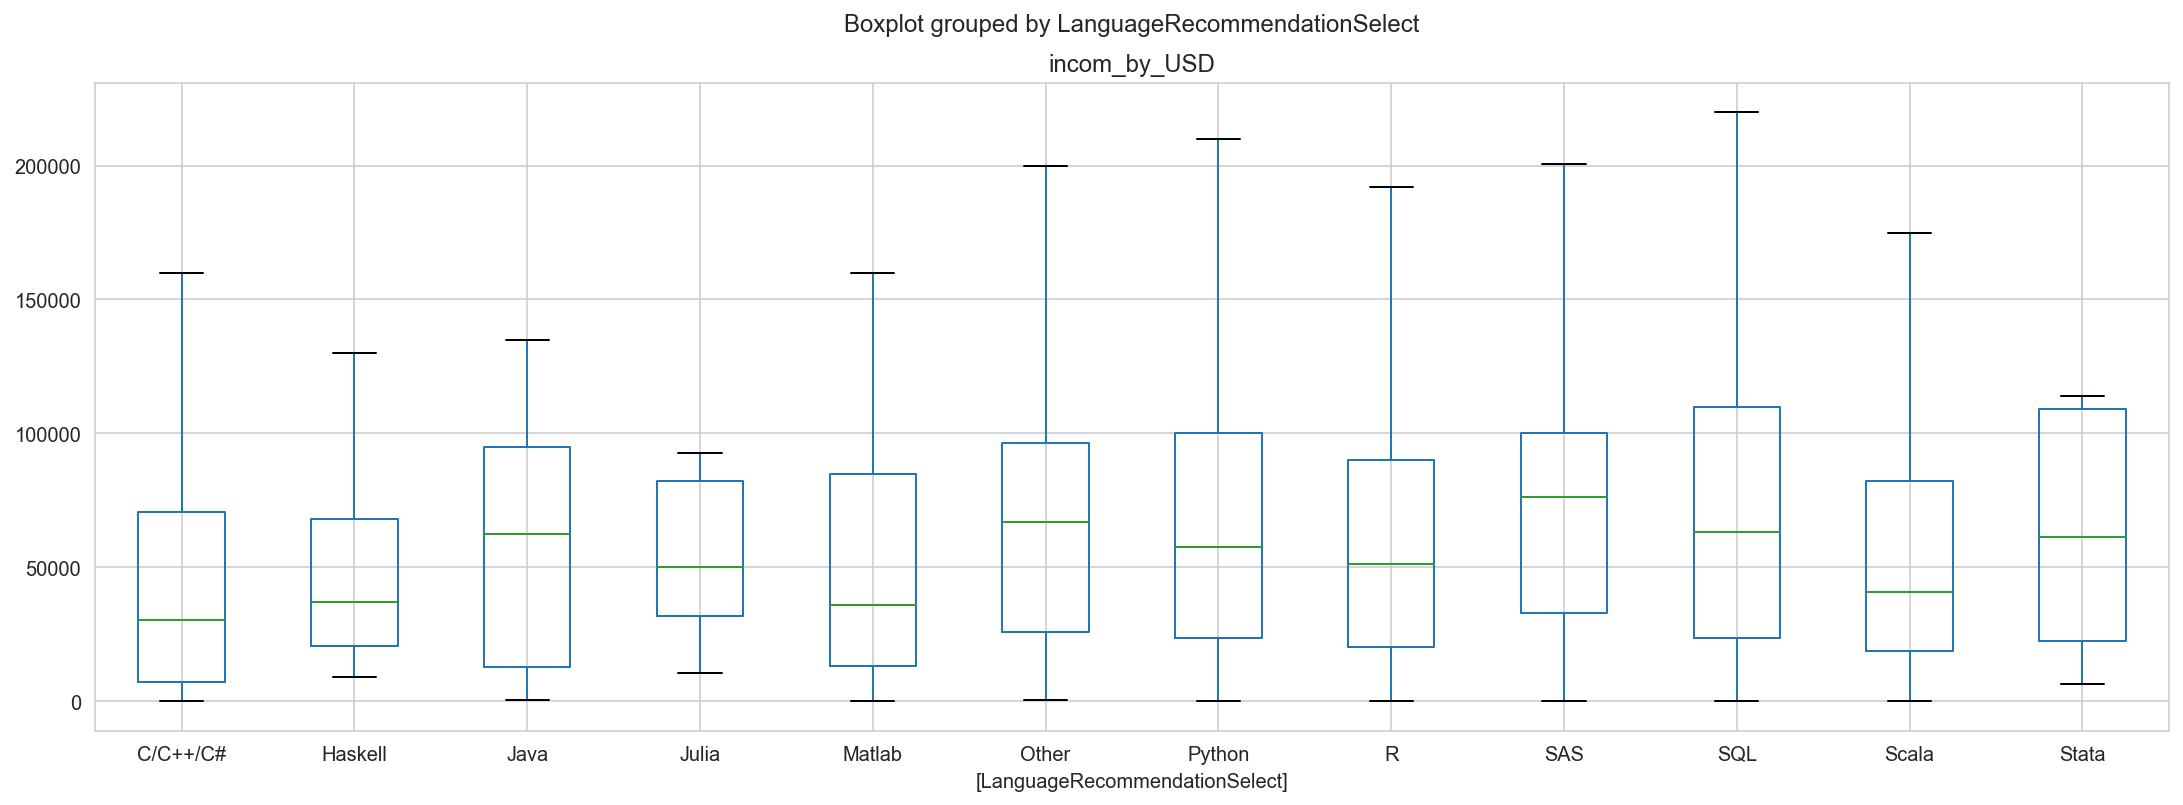

In [76]:
incom_df[['LanguageRecommendationSelect', 'incom_by_USD']].boxplot(by=['LanguageRecommendationSelect'], showfliers = False, figsize=(18, 6))